In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob

from scipy.signal import find_peaks


from IPython import display

**Summary**

This notebook generate matrix with features for matricies with Fourier spectrum for electrode and optical mapping. 

Features description:

-  *freq i* - frequency of i$^{th}$ heightest peak
-  *height i* - height of i$^{th}$ heightest peak
-  *width i* - width of i$^{th}$ heightest peak
-  *prominence i* - prominence of i$^{th}$ heightest peak
-  *#peaks_th* - number of peaks for given (th) threshhold
-  *low_freq_noise* - presence of low-frequency noise (frequency of one of the n highest peaks in the interval from 0 to lf_thHz)


### Upload data

In [382]:
path = r'C:\Users\Public\Documents\HRS'

In [383]:
el_sig = pd.read_csv(path + '\All FFT of electrode signal.csv', index_col=0)
om_sig = pd.read_csv(path + '\All FFT of optical signal.csv', index_col=0)

### Feature generation

In [384]:
"""
Function that generates pd.DataFrame with amount of peaks for (th*100)% threshhold. 

Parameters: 

full_df: Dataframe
Dataframe with fourier spectrum

th: float, from 0 to 1
threshhold

Returns: 

features: DataFrame, shape=(full_df[1]/2, 1)
number of peaks
"""

def number_of_peaks(full_df, th):
    all_props = []
    df = full_df[full_df.columns[::2]][:-1]
    for col in df:
        _, properties = find_peaks(df[col], height=0)
        all_props.append(properties)
    
    num_of_peaks = []
    
    for i in range(len(all_props)):
        max_height = np.max(all_props[i]['peak_heights'])
        peaks, _ = find_peaks(df.iloc[:,i], threshold=th*max_height)
        num = peaks.shape[0]
        num_of_peaks.append(num)
    num_of_peaks = pd.DataFrame(num_of_peaks, columns=['#peaks_' + str(th)])
    return(num_of_peaks)

In [385]:
number_of_peaks(el_sig, 0.05).head()

,#peaks_0.05
0,5
1,3
2,7
3,7
4,3


In [386]:
"""
Function that generates pd.DataFrame with different properties for n highest peaks. Properties - values of frequency, 
height, width of the peak for half peak height, prominence. 

In more details about properties https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

Parameters: 

full_df: Dataframe
Dataframe with fourier spectrum

n: int
number of peaks

lf_th: float
threshold for low frequency noise (1Hz by default)

Returns: 

features: DataFrame, shape=(full_df.shape[1]/2, n*4)
properties of n hightest peaks
"""

def properties_of_peaks(full_df, n, lf_th=1):
    
    all_peaks = []
    all_props = []
    df = full_df[full_df.columns[::2]][:-1]
    xf = full_df[full_df.columns[1::2]][:-1]
    
    for col in df:
        peaks, properties = find_peaks(df[col], height=0, width=0, prominence=0, rel_height=0.5)
        properties['peak_index'] = peaks
        all_props.append(properties)
        all_peaks.append(peaks)
        
    
    index = []
    freq = []
    height = []
    width = []
    prominence = []
    low_noise = []
    
    features = pd.DataFrame()
    
    for i in range(len(all_props)):
        z = np.argsort(all_props[i]['peak_heights'])
        z = z[:-(n+1):-1]
        idx = all_props[i]['peak_index'][z] #index of max peaks
        
        for j in range(n):
            fr = xf.iloc[:,i][all_peaks[i][z][j]] #freqs of max peaks
            freq.append(fr)
            
        h = all_props[i]['peak_heights'][z] #heights of max peaks
        height.append(h)
        w = all_props[i]['widths'][z] #width of max peaks
        width.append(w)
        p = all_props[i]['prominences'][z]
        prominence.append(p)

        
    freq = np.reshape(freq, (len(all_props), n)) 
    for i in range(freq.shape[0]):
        cond = np.where(freq[i] < lf_th)
#         print(cond[0])
#         print(cond[0].size)
        if cond[0].size == 0:
            low_noise.append(0)
        else:
            low_noise.append(1)
    freq = pd.DataFrame(freq, columns=['freq ' + str(i) for i in range(n)])
    height = pd.DataFrame(height, columns=['height ' + str(i) for i in range(n)])
    width = pd.DataFrame(width, columns=['width ' + str(i) for i in range(n)])
    prominence = pd.DataFrame(prominence, columns=['prominence ' + str(i) for i in range(n)])
    low_noise = pd.DataFrame(low_noise, columns=['low_freq_noise'])

    features = pd.concat([features, freq, height, width, prominence, low_noise], axis=1)
    
    return(features)

In [387]:
properties_of_peaks(el_sig, 3, 1).head(10)

,freq 0,freq 1,freq 2,height 0,height 1,height 2,width 0,width 1,width 2,prominence 0,prominence 1,prominence 2,low_freq_noise
0,8.487334,16.851663,0.615024,0.013464,0.008599,0.007835,2.107369,1.347714,1.242019,0.013246,0.008536,0.004159,1
1,8.487334,16.851663,0.738029,0.021348,0.015359,0.004381,2.084090,1.318957,2.294447,0.021204,0.015294,0.002769,1
2,8.487334,16.851663,5.043198,0.011128,0.009205,0.002923,2.137057,1.296551,1.201014,0.011093,0.009112,0.002840,0
3,16.851663,8.487334,0.615024,0.015052,0.014797,0.006998,1.314039,2.035020,1.874273,0.014973,0.014714,0.004862,1
4,8.487334,16.851663,12.669498,0.017404,0.008351,0.002373,2.034558,1.312960,1.071492,0.017341,0.008279,0.002267,0
5,11.940370,0.811481,0.347778,0.008116,0.003628,0.003385,1.410391,2.939132,1.163220,0.008113,0.003039,0.001848,1
6,11.940370,0.811481,0.231852,0.005226,0.003139,0.002060,1.404822,3.260891,0.665364,0.005203,0.002713,0.000540,1
7,11.940370,0.811481,0.231852,0.005191,0.004754,0.003292,1.360659,2.254402,1.301052,0.005103,0.003809,0.001732,1
8,4.057407,2.550370,11.824444,0.006272,0.005938,0.005570,5.163648,4.122266,2.036408,0.005882,0.004228,0.005305,0
9,12.250000,0.750000,1.625000,0.011154,0.007526,0.005812,1.193836,6.492907,2.306966,0.010779,0.006526,0.002967,1


In [396]:
"""
Function that generates final pd.DataFrame with all features

Parameters: 

full_df: Dataframe
Dataframe with fourier spectrum

n: int
number of peaks

th1: float, from 0 to 1
threshhold

th2: float, from 0 to 1
threshhold

lf_th: float
low frequency threshhold

path: str
path to save the matrix

download: bool
download or not download feature matrix

Returns: 

features: DataFrame
features for full_df dataframe
"""

def create_feature_df(full_df, n, th1, th2, lf_th, path, download=False):
    
    features = pd.DataFrame()
    
    properties = properties_of_peaks(full_df=full_df, n=n, lf_th=lf_th) 
    num_peak_1 = number_of_peaks(full_df=full_df, th=th1)
    num_peak_2 = number_of_peaks(full_df=full_df, th=th2)
    target = pd.DataFrame(el_sig[el_sig.columns[::2]].loc['target'].reset_index().drop('index',axis=1))
    
    features = pd.concat([features, num_peak_1, num_peak_2, properties], axis=1)
    features = pd.concat([features, target], axis=1)
    
    if download == True: 
        features.to_csv(path + '\Feature matrix.csv')
        return(features)
    else:
        return(features)

In [413]:
create_feature_df(el_sig, n=3, th1=0.05, th2=0.1, lf_th=1.5, path=path, download=True).head()

,#peaks_0.05,#peaks_0.1,freq 0,freq 1,freq 2,height 0,height 1,height 2,width 0,width 1,width 2,prominence 0,prominence 1,prominence 2,low_freq_noise,target
0,5,3,8.487334,16.851663,0.615024,0.013464,0.008599,0.007835,2.107369,1.347714,1.242019,0.013246,0.008536,0.004159,1,1.0
1,3,2,8.487334,16.851663,0.738029,0.021348,0.015359,0.004381,2.084090,1.318957,2.294447,0.021204,0.015294,0.002769,1,1.0
2,7,5,8.487334,16.851663,5.043198,0.011128,0.009205,0.002923,2.137057,1.296551,1.201014,0.011093,0.009112,0.002840,0,1.0
3,7,6,16.851663,8.487334,0.615024,0.015052,0.014797,0.006998,1.314039,2.035020,1.874273,0.014973,0.014714,0.004862,1,1.0
4,3,3,8.487334,16.851663,12.669498,0.017404,0.008351,0.002373,2.034558,1.312960,1.071492,0.017341,0.008279,0.002267,0,1.0


In [416]:
feature_matrix = pd.read_csv(path + '\Feature matrix.csv', index_col=0)
feature_matrix.head()

,#peaks_0.05,#peaks_0.1,freq 0,freq 1,freq 2,height 0,height 1,height 2,width 0,width 1,width 2,prominence 0,prominence 1,prominence 2,low_freq_noise,target
0,5,3,8.487334,16.851663,0.615024,0.013464,0.008599,0.007835,2.107369,1.347714,1.242019,0.013246,0.008536,0.004159,1,1.0
1,3,2,8.487334,16.851663,0.738029,0.021348,0.015359,0.004381,2.084090,1.318957,2.294447,0.021204,0.015294,0.002769,1,1.0
2,7,5,8.487334,16.851663,5.043198,0.011128,0.009205,0.002923,2.137057,1.296551,1.201014,0.011093,0.009112,0.002840,0,1.0
3,7,6,16.851663,8.487334,0.615024,0.015052,0.014797,0.006998,1.314039,2.035020,1.874273,0.014973,0.014714,0.004862,1,1.0
4,3,3,8.487334,16.851663,12.669498,0.017404,0.008351,0.002373,2.034558,1.312960,1.071492,0.017341,0.008279,0.002267,0,1.0


-------------------------------------------------------

#### Everything below this line is garbage

In [222]:
properties_of_peaks(el_sig, 1).shape

(895, 4)

In [206]:
peaks, properties = find_peaks(el_sig.iloc[:,6], height=0, prominence=0, width=0)
# properties['peak_index'] = peaks
z = np.argsort(properties['peak_heights'])
z = z[:-3:-1]
el_sig.iloc[:,7][peaks[z]]

136    16.851663
68      8.487334
Name: Bsk 2 D4_xf, dtype: float64

In [105]:
peaks, properties = find_peaks(el_sig.iloc[:,0], height=0, prominence=0, width=0)
properties['peak_index'] = peaks
z = np.argsort(properties['peak_heights'])
z = z[:-2:-1]
h = properties['peak_heights'][z]
h
# index = np.argsort(properties['peak_heights'])
# m = np.argmax(properties['peak_heights'])
# index[:-5:-1]

array([0.01346359])

In [17]:
a = np.argsort(el_sig.iloc[:,0])
a[:-5:-1]

199     68
198     67
197    136
196      4
Name: Bsk 1 B5_yf, dtype: int64

In [62]:
el_num_5 = number_of_peaks(el_sig, 0.05)
el_num_10 = number_of_peaks(el_sig, 0.1)
el_features = pd.concat([el_features, el_num_5, el_num_10], axis=1)

In [72]:
892*2

1784

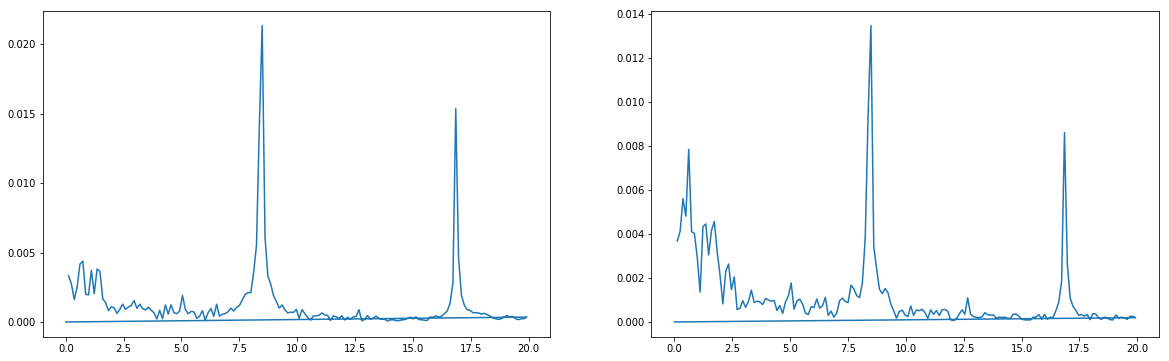

In [218]:
fig = plt.figure(figsize=(20, 6))
ax = fig.subplots(1, 2)

y1 = el_sig.iloc[:,2]
x1 = el_sig.iloc[:,3]
y2 = el_sig.iloc[:,0]
x2 = el_sig.iloc[:,1]

ax[0].plot(x1, y1)
ax[1].plot(x2, y2)



In [208]:
peaks, properties = find_peaks(y1, height=0)

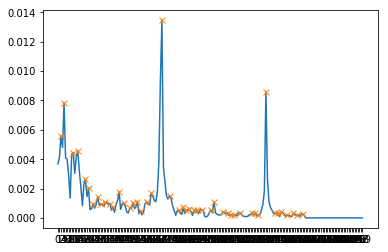

47


In [209]:
max_height = np.max(properties['peak_heights'])
peaks, properties = find_peaks(y1, threshold = 0)


plt.plot(y1)
plt.plot(peaks, y1[peaks], "x")
plt.show()
print(peaks.shape[0])

In [79]:
properties

{'left_thresholds': array([1.68985745e-01, 1.09850929e-03, 1.63293153e-04, 1.18094217e-02,
        5.15826835e-03, 6.44266950e-03, 1.39914417e-02, 1.58514129e-02,
        2.65309969e-03, 7.62701927e-03, 1.86963235e-03, 2.06579531e-03,
        3.29771573e-03, 5.40716414e-03, 3.27774951e-05, 7.21727514e-03,
        1.92298803e-03, 7.33632455e-04, 2.67908434e-03, 4.18985480e-03,
        5.34531908e-04, 2.31519893e-03, 4.08999904e-03, 1.41248776e-03,
        2.21224055e-03, 2.16016361e-03, 6.27102401e-04, 1.64346599e-03,
        1.41708693e-03, 2.08609207e-03, 2.79748243e-04, 1.19132806e-03,
        1.01449898e-03, 1.39476230e-03, 1.25887459e-04, 3.78032634e-04,
        1.29690036e-03, 1.15860530e-04, 5.37731431e-04, 6.55434016e-04,
        8.60623789e-04, 1.26943607e-03, 7.51979490e-05, 6.97984049e-05,
        8.52939767e-04, 2.33374608e-05, 3.67471298e-04, 7.09896745e-04]),
 'right_thresholds': array([0.05161102, 0.04416179, 0.02864188, 0.01300526, 0.02020081,
        0.01600428, 0.01229

In [129]:
np.max(el_props[0]['peak_heights'])
# el_props[0]['peak_heights'][-4:]


0.013463587025090335

In [79]:
peaks

array([  4,   7,  11,  17,  20,  22,  24,  28,  30,  33,  36,  39,  42,
        44,  47,  50,  55,  58,  60,  62,  64,  66,  68,  70,  78,  88,
        90,  94,  96, 100, 102, 104, 106, 108, 111, 113, 118, 121, 123,
       128, 131, 133, 137, 139, 141, 143, 145, 147, 149, 153, 156],
      dtype=int64)

dict_keys(['peak_heights'])

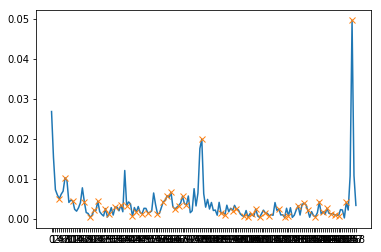

In [100]:
plt.plot(el_sig.iloc[:-42,78])
plt.plot(peaks, el_sig.iloc[:-42,78][peaks], "x")
plt.show()
